# Windy gridworld with $n$-step SARSA

The target for for $n$-step SARSA is

$$
    y(s,a) = \sum_{k=1}^n \gamma^{k-1}\,r_{t+n} + \gamma^n Q(s_{t+n}, a_{t+n}).
$$

The update takes the form
$$
    Q(s, a) = Q(s, a) + \alpha\,[y(s,a) - Q(s,a)]
$$

In [1]:
from tabrl import agents, gridworld

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from numba import njit
from itertools import product

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
n_rows = 7
n_cols = 10

In [6]:
movements = np.array([
    [0, 1], # right   (0)
    [0, -1], # left   (1)
    [1, 0], # down,   (2)
    [-1, 0], # up     (3)
    [0, 0], # nothing (4)
])
n_actions = len(movements)

name_movements = ["right", "left", "down", "up"]
name_movements = ["right", "left", "down", "up", "nothing"]

In [7]:
start_ix = 30
end_ix = 37
reward_goal =  20
G = gridworld.WindyGridworld(start_ix, end_ix, n_rows, n_cols, reward_goal)

In [8]:
G.map_ix

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69]], dtype=int32)

## $n$-step SARSA updates

In [9]:
def update_buffer(buffer, new_element):
    """
    Update buffer FIFO mode.
    We assume that elements in the buffer are time-ordered
    along the first axis.

    Parameters
    ----------
    buffer: np.array
        (B, ...)
    new_element: np.array
        (...,)
    """
    buffer = np.roll(buffer, -1, axis=0)
    buffer[-1] = new_element
    return buffer

In [182]:
base_seed = 314
n_steps = 10_000
epsilon = 0.01
alpha = 0.5
gamma = 1.0

In [313]:
buffer_size = 10

buffer_rewards = np.zeros(buffer_size) * np.nan
buffer_actions = np.zeros(buffer_size + 1) * np.nan
buffer_states = np.zeros(buffer_size + 1) * np.nan

Q = np.zeros((G.n_rows * G.n_cols, n_actions)) # action-value function


agents.set_seed(base_seed - 1)
ix = start_ix
action = agents.choose_action(ix, Q, epsilon)
ix_hist = [ix]
action_hist = [action]
reward_hist = [0]

buffer_states = update_buffer(buffer_states, ix)
buffer_actions = update_buffer(buffer_actions, action)

for t in range(n_steps):
    agents.set_seed(base_seed + t)

    # 1. take step, obtain reward and new state
    r, ix_new = G.step(ix, action, movements)

    # 2. Select the new action based on Q and the new state
    # epsilon-greedy style
    action_new = agents.choose_action(ix_new, Q, epsilon)

    # 3. Update buffers:
    # insert newest (state/action/reward) and remove oldest (state/action/reward)
    buffer_states = update_buffer(buffer_states, ix_new)
    buffer_actions = update_buffer(buffer_actions, action_new)
    buffer_rewards = update_buffer(buffer_rewards, r)

    # 3.1. Upate elements
    ix, action = ix_new, action_new

    action_hist.append(action)
    ix_hist.append(ix)
    reward_hist.append(r)

    
    # 3.2 Continue interacting with the environment without updates until
    # the buffer is full or we reach an end state
    is_buffer_full = not np.isnan(buffer_rewards).any()
    end_state_reached = (ix == G.ix_goal)

    if not is_buffer_full:
        if not end_state_reached:
            continue

    # 4.1 Update the Q-values using N-step sarsa
    if not end_state_reached:
        # 4. Select new action based on buffer rewards,
        # last action taken and last encountered state
        Q = agents.nstep_sarsa_update(
            buffer_states, buffer_actions, buffer_rewards, Q, alpha, gamma, end_state_reached
        )
    # 4.2. Update the Q-values MC-style, i.e., we do not bootstrap
    else:
        for b in np.arange(buffer_size):
            Q = agents.nstep_sarsa_update(
                buffer_states, buffer_actions, buffer_rewards, Q, alpha, gamma, end_state_reached
            )
    
            # Flush oldest element from buffers
            buffer_rewards = update_buffer(buffer_rewards, np.nan)
            buffer_actions = update_buffer(buffer_actions, np.nan)
            buffer_states = update_buffer(buffer_states, np.nan)

            if np.isnan(buffer_rewards).all():
                break


action_hist = np.array(action_hist)
ix_hist = np.array(ix_hist)
reward_hist = np.array(reward_hist)

In [314]:
ix_goal = np.where(reward_hist == reward_goal)[0]
pos_hist = np.c_[ix_hist % n_cols, ix_hist // n_cols]
distance_hist = np.abs(pos_hist - G.get_pos(end_ix)).sum(axis=1)

n_runs = len(ix_goal)
n_runs

300

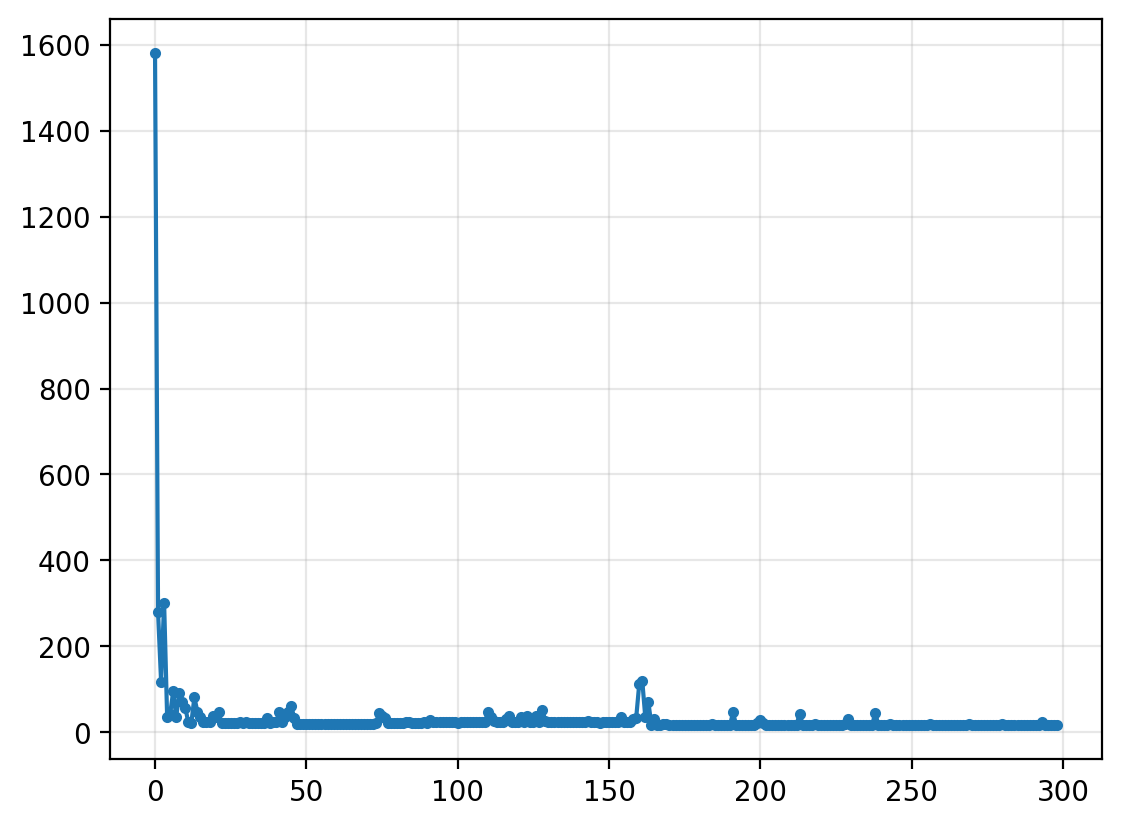

In [320]:
# TODO: make cropped plot
plt.plot(np.diff(ix_goal), marker="o", markersize=3)
plt.grid(alpha=0.3)

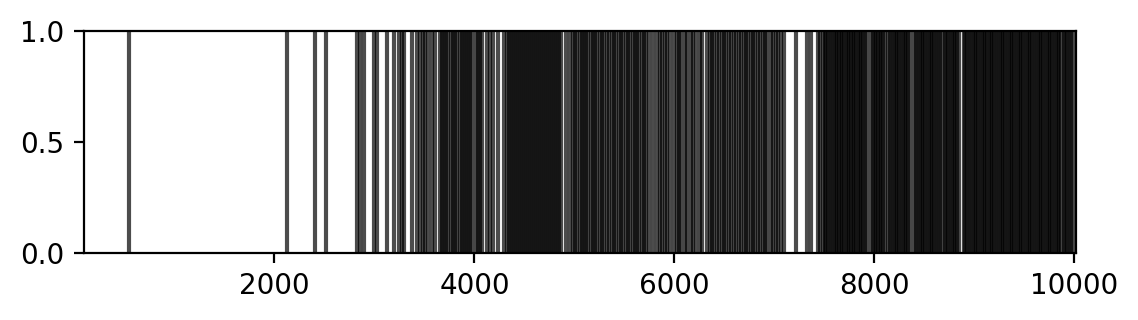

In [317]:
fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.3))
goals_ix = np.where(reward_hist == G.reward_goal)[0]
for gix in goals_ix:
    plt.axvline(x=gix, c="Black", alpha=0.7)

In [318]:
markers

{'down': 'v', 'up': '^', 'right': '>', 'left': '<', 'nothing': 'o'}

<Axes: >

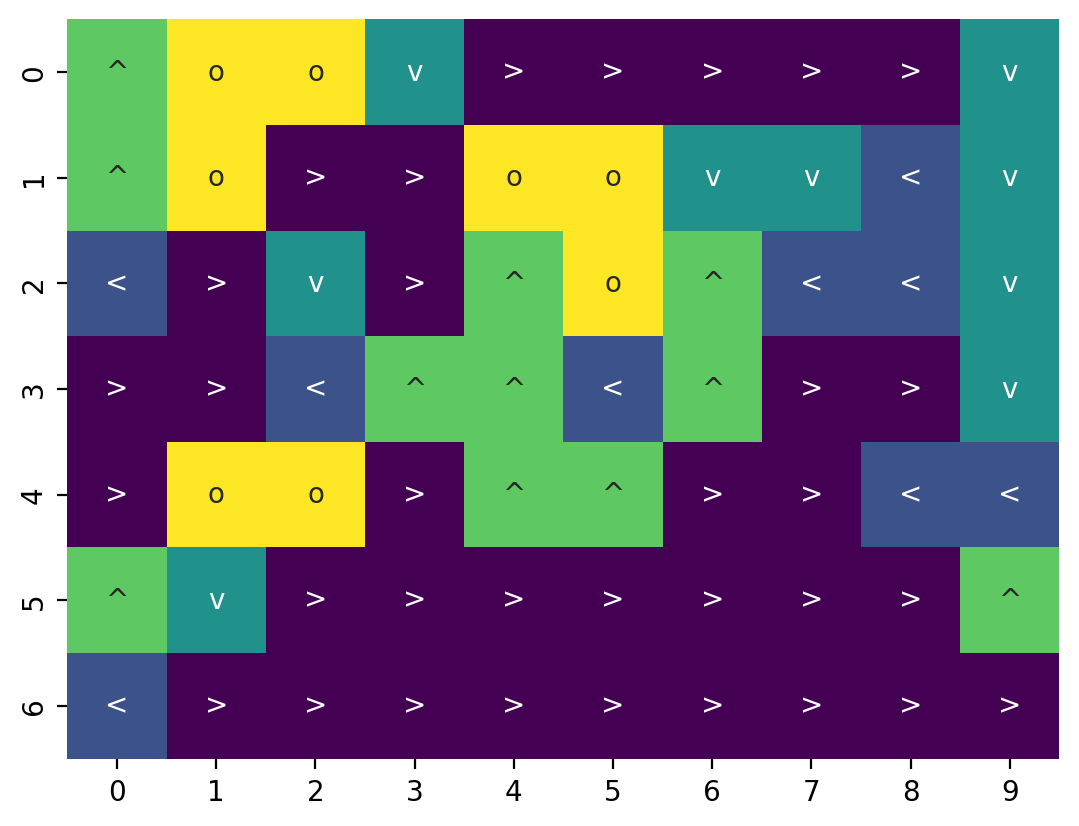

In [319]:
policy = Q.argmax(axis=1)
policy = pd.DataFrame({
    "policy": policy,
    "annot": [markers[name_movements[a]] for a in policy]
})

sns.heatmap(
    data=policy["policy"].values.reshape(G.n_rows, G.n_cols),
    annot=policy["annot"].values.reshape(G.n_rows, G.n_cols),
    cmap="viridis",
    cbar=False,
    fmt="",
)

In [245]:
markers = {
    "down": "v",
    "up": "^",
    "right": ">",
    "left": "<",
    "nothing": "o"
}

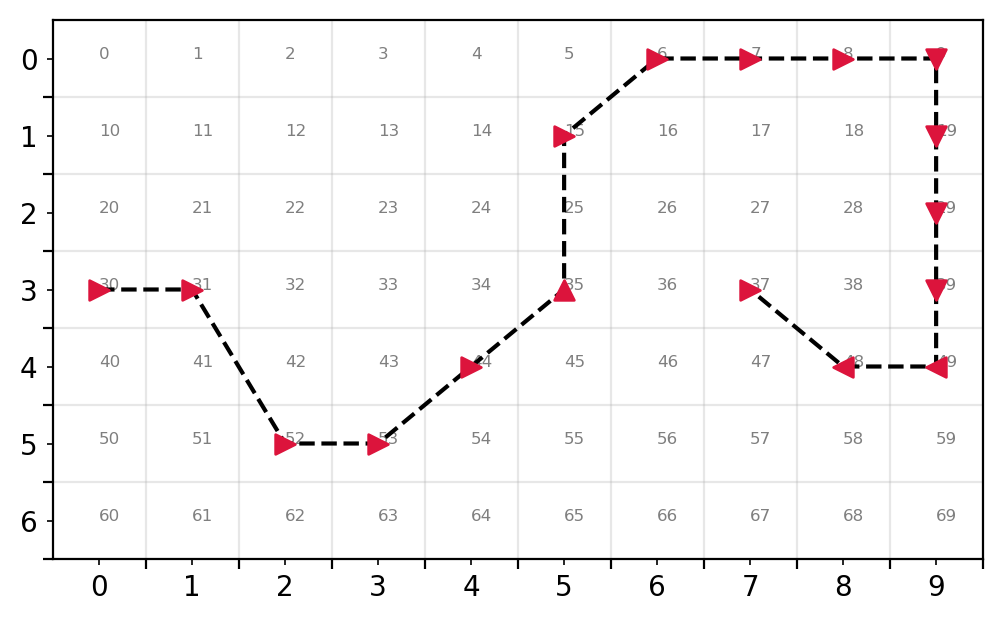

In [246]:
run = -2
iinit = ix_goal[run]
iend = ix_goal[run + 1]

subhist_action = action_hist[iinit:iend]
subhist_action = [name_movements[a] for a in subhist_action]
subhist_action = [markers[action] for action in subhist_action]

subhist_pos = pos_hist[iinit:iend]

fig, ax = plt.subplots(figsize=(n_cols * 0.6, n_rows * 0.5))
plt.plot(*subhist_pos.T, c="black", linestyle="--")

for (x,y), m in zip(subhist_pos, subhist_action):
    plt.scatter(x, y, marker=m, zorder=3, s=50, c="crimson")

xticks = np.arange(n_cols)
yticks = np.arange(n_rows)
ax.set(
    xticks=xticks + 0.5,
    yticks=yticks + 0.5,
    xticklabels="",
    yticklabels="",
)
ax.set_xticks(xticks, labels=xticks, minor=True)
ax.set_yticks(yticks, labels=yticks, minor=True)

# ax.scatter(*pos_hist[iinit], marker="$S$", s=100, zorder=3)
# ax.scatter(*pos_hist[iend-1], marker="$G$", s =100, c="crimson", zorder=3)
ax.set_ylim(-0.5, n_rows - 0.5)
ax.set_xlim(-0.5, n_cols - 0.5)
ax.invert_yaxis()


for i, (r, c) in enumerate(product(range(G.n_rows), range(G.n_cols))):
    plt.text(c, r, i, c="tab:gray", zorder=0, fontsize=6)

plt.grid(alpha=0.3)
# plt.savefig("windy-gridworld.png", bbox_inches="tight", dpi=150)

## SARSA updates

The implementation below is clean, but it treats the episodic task as a continuing task.

In [16]:
%%time
Q = np.zeros((G.n_rows * G.n_cols, n_actions)) # action-value function

epsilon = 0.01
alpha = 0.5
gamma = 1.0

agents.set_seed(314-1)
ix = start_ix
action = agents.choose_action(ix, Q, epsilon)
ix_hist = [ix]
action_hist = [action]
reward_hist = [0]

for i in range(5_000):
    agents.set_seed(314 + i)

    # 1. take step, obtain reward and new state
    r, ix_new = G.step(ix, action, movements)
    
    # 2. Choose 'a_new' based on Q and 's_new'
    action_new = agents.choose_action(ix_new, Q, epsilon)

    # 3. Update agent based on state, new-state, action taken, and reward
    Q = agents.sarsa_update(ix, action, r, ix_new, action_new, Q, alpha, gamma, epsilon)

    ix, action = ix_new, action_new

    action_hist.append(action)
    ix_hist.append(ix)
    reward_hist.append(r)

action_hist = np.array(action_hist)
ix_hist = np.array(ix_hist)
reward_hist = np.array(reward_hist)

CPU times: user 54.3 ms, sys: 1.9 ms, total: 56.2 ms
Wall time: 56.3 ms


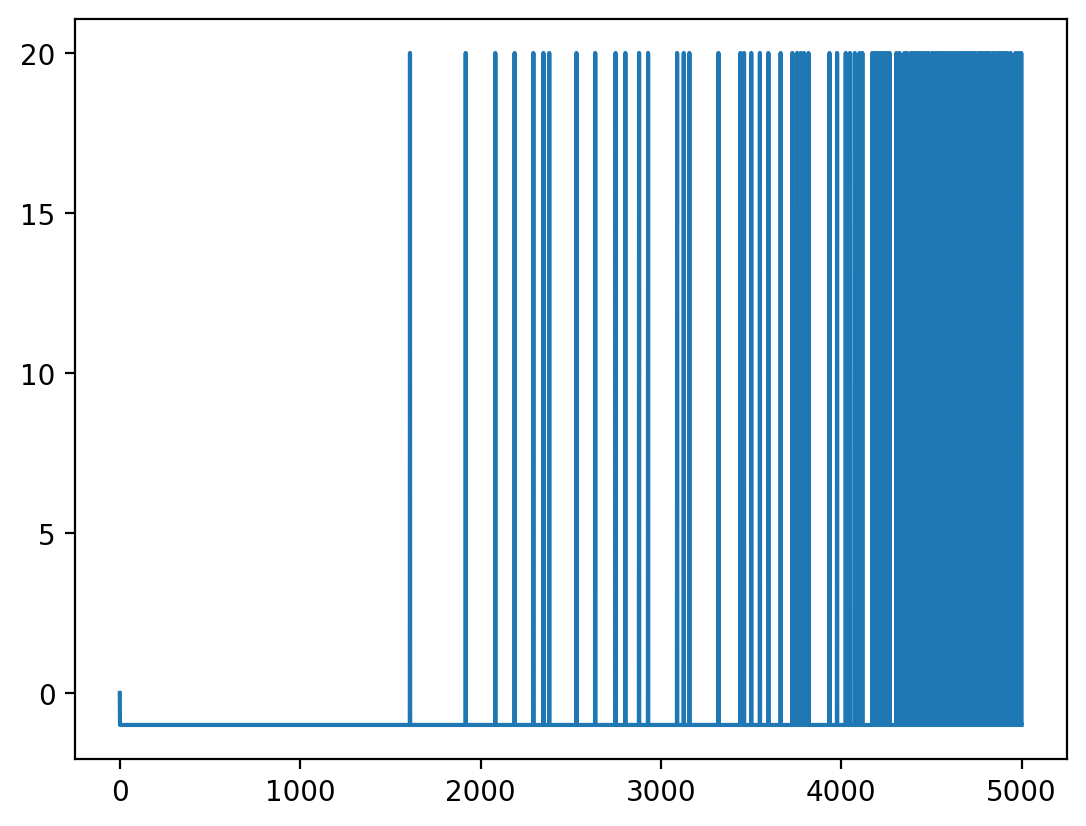

In [17]:
plt.plot(reward_hist)

In [18]:
ix_goal = np.where(reward_hist == reward_goal)[0]
pos_hist = np.c_[ix_hist % n_cols, ix_hist // n_cols]
distance_hist = np.abs(pos_hist - G.get_pos(end_ix)).sum(axis=1)
len(ix_goal)

84

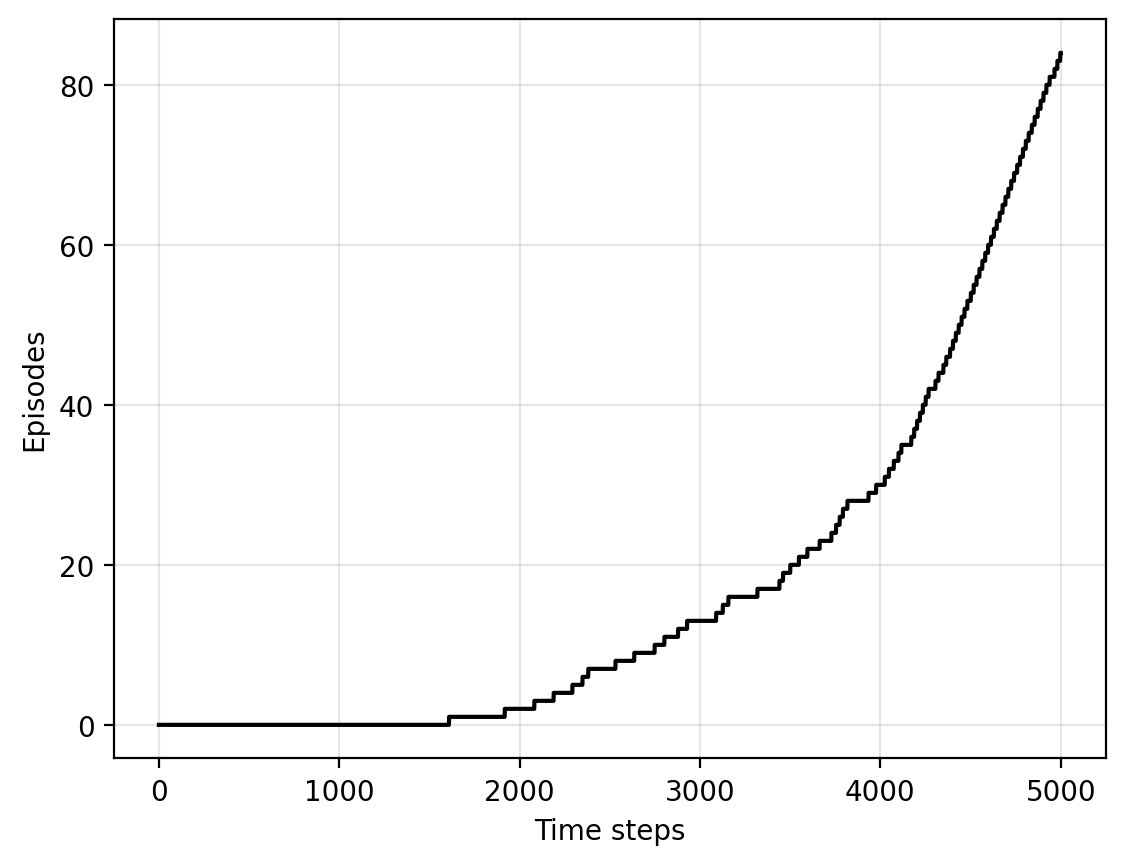

In [19]:
plt.plot((reward_hist == reward_goal).cumsum(), c="black")
plt.grid(alpha=0.3)
plt.xlabel("Time steps")
plt.ylabel("Episodes");

In [20]:
markers = {
    "down": "v",
    "up": "^",
    "right": ">",
    "left": "<",
    "nothing": "o"
}

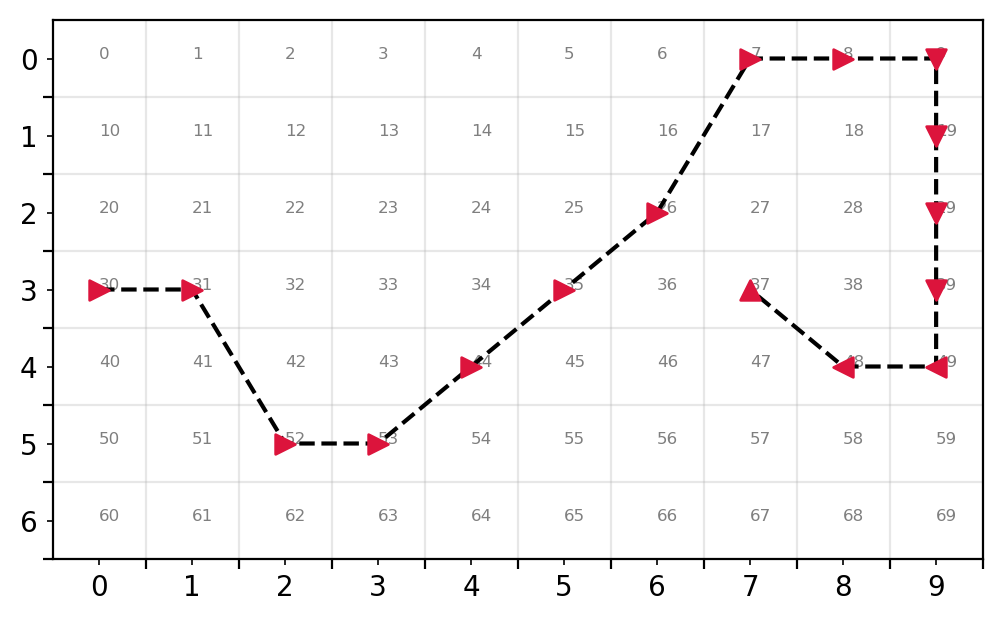

In [21]:
run = -2
iinit = ix_goal[run]
iend = ix_goal[run + 1]

subhist_action = action_hist[iinit:iend]
subhist_action = [name_movements[a] for a in subhist_action]
subhist_action = [markers[action] for action in subhist_action]

subhist_pos = pos_hist[iinit:iend]

fig, ax = plt.subplots(figsize=(n_cols * 0.6, n_rows * 0.5))
plt.plot(*subhist_pos.T, c="black", linestyle="--")

for (x,y), m in zip(subhist_pos, subhist_action):
    plt.scatter(x, y, marker=m, zorder=3, s=50, c="crimson")

xticks = np.arange(n_cols)
yticks = np.arange(n_rows)
ax.set(
    xticks=xticks + 0.5,
    yticks=yticks + 0.5,
    xticklabels="",
    yticklabels="",
)
ax.set_xticks(xticks, labels=xticks, minor=True)
ax.set_yticks(yticks, labels=yticks, minor=True)

# ax.scatter(*pos_hist[iinit], marker="$S$", s=100, zorder=3)
# ax.scatter(*pos_hist[iend-1], marker="$G$", s =100, c="crimson", zorder=3)
ax.set_ylim(-0.5, n_rows - 0.5)
ax.set_xlim(-0.5, n_cols - 0.5)
ax.invert_yaxis()


for i, (r, c) in enumerate(product(range(G.n_rows), range(G.n_cols))):
    plt.text(c, r, i, c="tab:gray", zorder=0, fontsize=6)

plt.grid(alpha=0.3)
# plt.savefig("windy-gridworld.png", bbox_inches="tight", dpi=150)